In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import 

# Download the most recent stock data

In [294]:
## run python script
!python apache_data.py

Saved intraday data: (4032, 5)
Saved daily data: (57, 5)
Saved intraday data: (1344, 5)
Saved daily data: (57, 5)
Saved intraday data: (672, 5)
Saved daily data: (57, 5)


# Day Level Data

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [296]:
def read_csv_correct_time(file_path, assume="ET"):
    """
    Pass a csv file from apache data api and turn that into a dataframe that has
    accurate timezone (NYC) with close and volume columns.
    """
    df = pd.read_csv(file_path)

    # Parse the column into datetimes
    ts = pd.to_datetime(df["date"], errors="raise")

    # Build a tz-aware DatetimeIndex in America/New_York
    if hasattr(ts, "dt") and ts.dt.tz is not None:
        # Already tz-aware → just convert to NY
        idx = ts.dt.tz_convert("America/New_York")
        idx = idx.tz_localize(None) 
    else:
        # Naive timestamps → decide what they mean
        if assume.upper() == "UTC":
            idx = pd.DatetimeIndex(ts, tz="UTC").tz_convert("America/New_York")
            idx = idx.tz_localize(None)   # strips it off
        else:  # assume they are already Eastern local time
            idx = pd.DatetimeIndex(ts, tz="America/New_York")
            idx = idx.tz_localize(None)   # strips it off

    # Use the tz-aware index
    df = df.set_index(idx)
    # Optional: drop the original column
    df = df.drop(df.columns[0], axis=1)

    # Filter to Regular Trading Hours
    df_rth = df.between_time("09:30", "16:00")
    df_rth = df_rth[["4. close", "5. volume"]]  # keep only close and volume
    df_rth.columns = ["close", "volume"]

    return df_rth

In [304]:
df_5min = read_csv_correct_time('data/CRCL_5min_2025-07-28_to_2025-08-25.csv')
df_15min = read_csv_correct_time('data/CRCL_15min_2025-07-28_to_2025-08-25.csv')

In [305]:
def visualize_feature_trend_by_time(df, feature, look_back_days=20):
    """
    Visualize the trend of a specific feature by time of day over a look-back period.
    """
    date_column = df.index.date
    time_column = df.index.time
    
    df_pivot = df.pivot_table(
        index=date_column,
        columns=time_column,
        values=feature
    )

    avg_feature_by_time = df_pivot.tail(look_back_days).mean(axis=0)
    avg_feature_by_time.name = f"Average {feature}"

    time_as_dt = pd.to_datetime(avg_feature_by_time.index.astype(str), format="%H:%M", errors="coerce")
    order = time_as_dt.argsort()
    avg_sorted = avg_feature_by_time.iloc[order]
    tick_labels = avg_feature_by_time.index.astype(str).to_numpy()[order]

    plt.figure(figsize=(12, 6))

    for _, row in df_pivot.iterrows():
        y = row.iloc[order].values
        plt.plot(tick_labels, y, alpha=0.18, linewidth=1)

    plt.plot(tick_labels, avg_sorted.values, linewidth=2)

    plt.title(f"Average {feature} by Time of Day from {df.index.get_level_values('date').min()} to {df.index.get_level_values('date').max()}")
    plt.xlabel("Time of Day")
    plt.ylabel(f"average {feature}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return avg_feature_by_time

# 5MIN

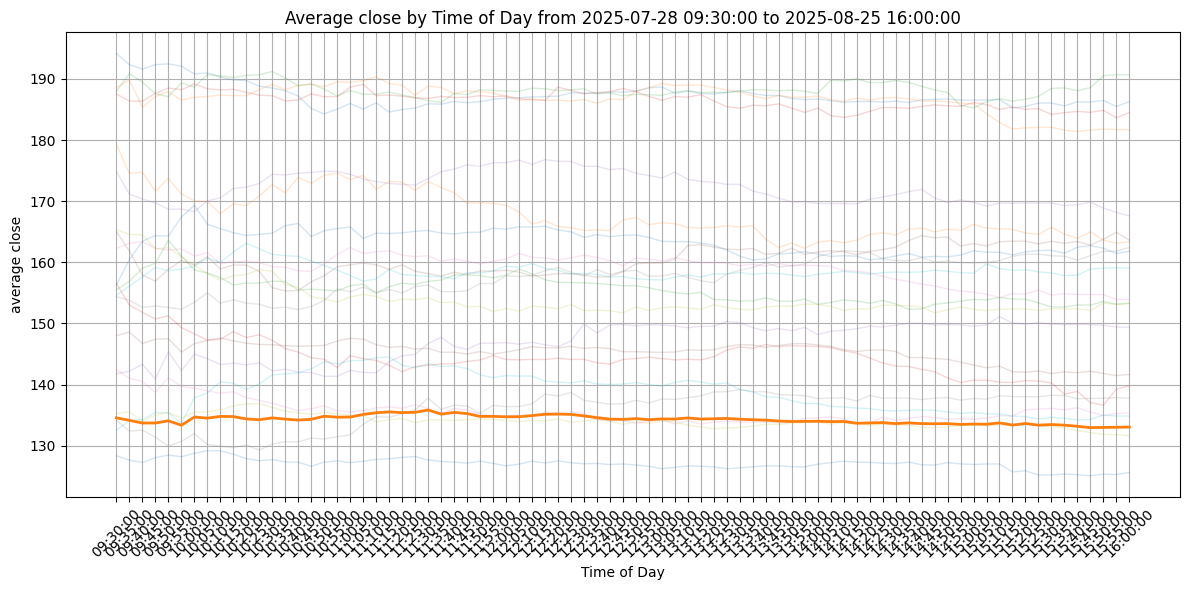

09:30:00    134.54702
09:35:00    134.12688
09:40:00    133.69600
09:45:00    133.70290
09:50:00    134.05800
              ...    
15:40:00    133.16340
15:45:00    132.94012
15:50:00    132.97700
15:55:00    133.00200
16:00:00    133.03374
Name: Average close, Length: 79, dtype: float64

In [306]:
visualize_feature_trend_by_time(df_5min, feature="close", look_back_days=5)

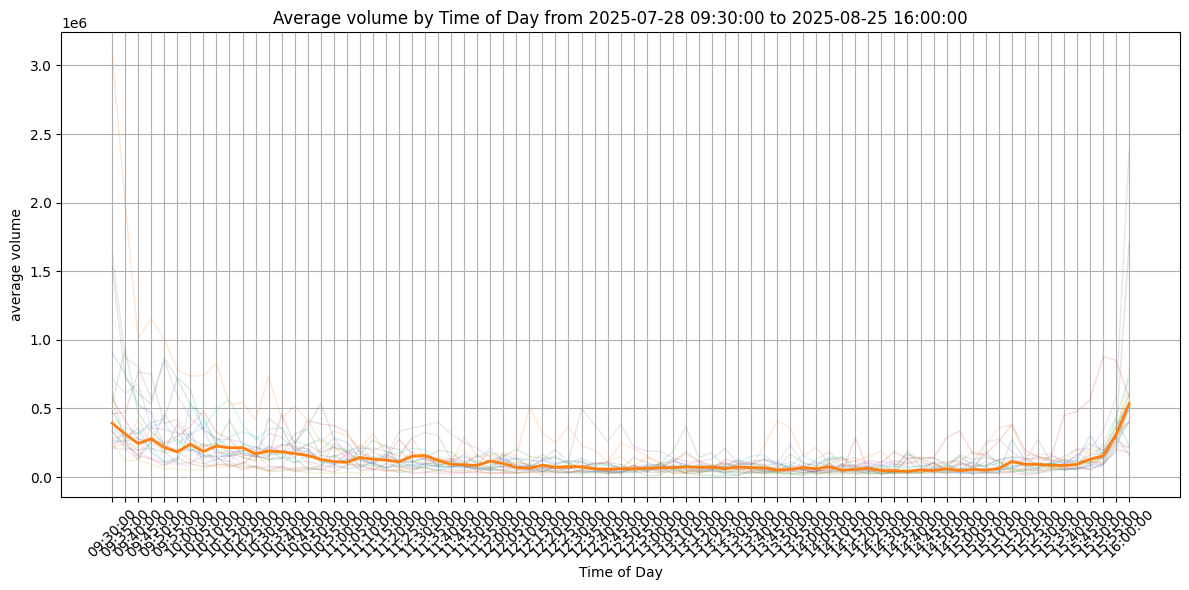

09:30:00    393012.0
09:35:00    313602.8
09:40:00    244353.6
09:45:00    279461.2
09:50:00    216098.6
              ...   
15:40:00     92375.6
15:45:00    130221.2
15:50:00    154908.4
15:55:00    308265.6
16:00:00    535391.0
Name: Average volume, Length: 79, dtype: float64

In [307]:
visualize_feature_trend_by_time(df_5min, feature="volume", look_back_days=5)

# 15MIN

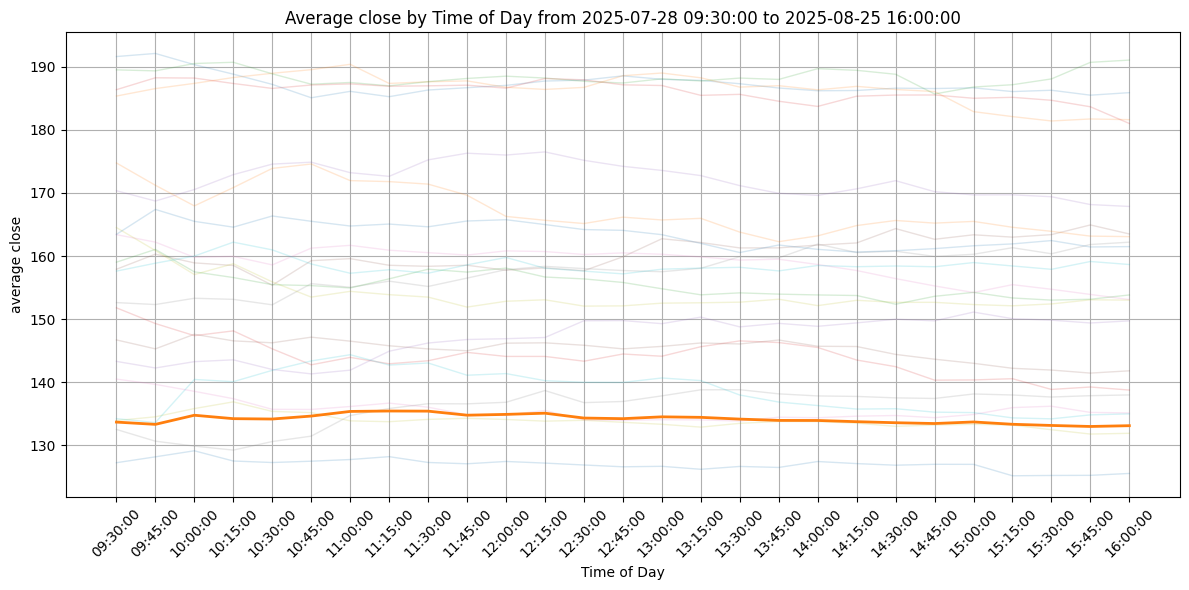

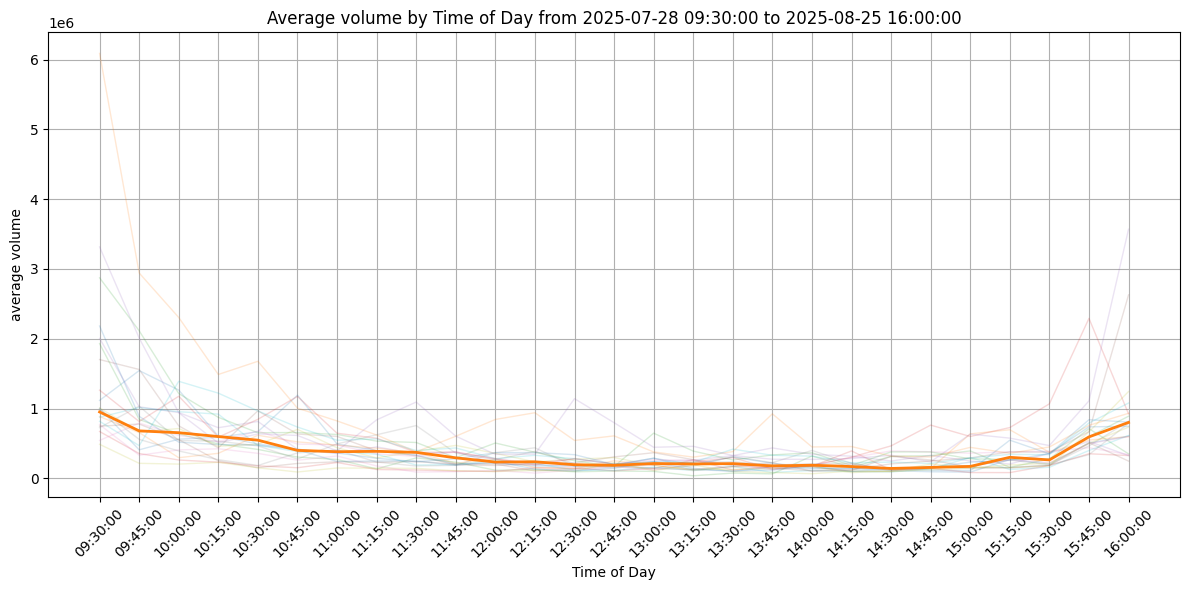

09:30:00    950968.4
09:45:00    679373.6
10:00:00    653490.6
10:15:00    597998.4
10:30:00    546405.8
10:45:00    399916.2
11:00:00    381106.2
11:15:00    386475.2
11:30:00    371930.6
11:45:00    293105.4
12:00:00    232850.0
12:15:00    236646.4
12:30:00    194784.0
12:45:00    186334.0
13:00:00    212040.6
13:15:00    205220.6
13:30:00    210748.2
13:45:00    177218.6
14:00:00    187645.8
14:15:00    168084.0
14:30:00    141181.8
14:45:00    155765.6
15:00:00    170564.4
15:15:00    300747.0
15:30:00    263465.6
15:45:00    593395.2
16:00:00    800679.8
Name: Average volume, dtype: float64

In [308]:
visualize_feature_trend_by_time(df_15min, feature="close", look_back_days=5)
visualize_feature_trend_by_time(df_15min, feature="volume", look_back_days=5)

## Daily Volume

In [314]:
def daily_data_feature(df_daily, feature, lookback=20):
    # Rename columns for consistency
    df_daily = df_daily.copy()  # ensure we’re not working on a view
    df_daily.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    
    # Select only needed columns
    df_daily = df_daily.loc[:, ["date", feature]].copy()
    
    # Convert date and set timezone
    df_daily.loc[:, "date"] = pd.to_datetime(df_daily["date"]).dt.tz_localize("America/New_York")
    
    # Set index
    df_daily = df_daily.set_index('date')
    
    # Extract feature as Series
    df_feature = df_daily[feature]

    # plot the graph
    plt.figure(figsize=(20, 10))
    df_feature.plot(title=f"Daily {feature.capitalize()} with {lookback}-Day Lookback", marker='o', grid=True)
    plt.xticks(df_daily.index, rotation=90)
    plt.xlabel("Date")
    plt.ylabel(feature.capitalize())
    plt.show()

    return df_feature

/Users/linguoren/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


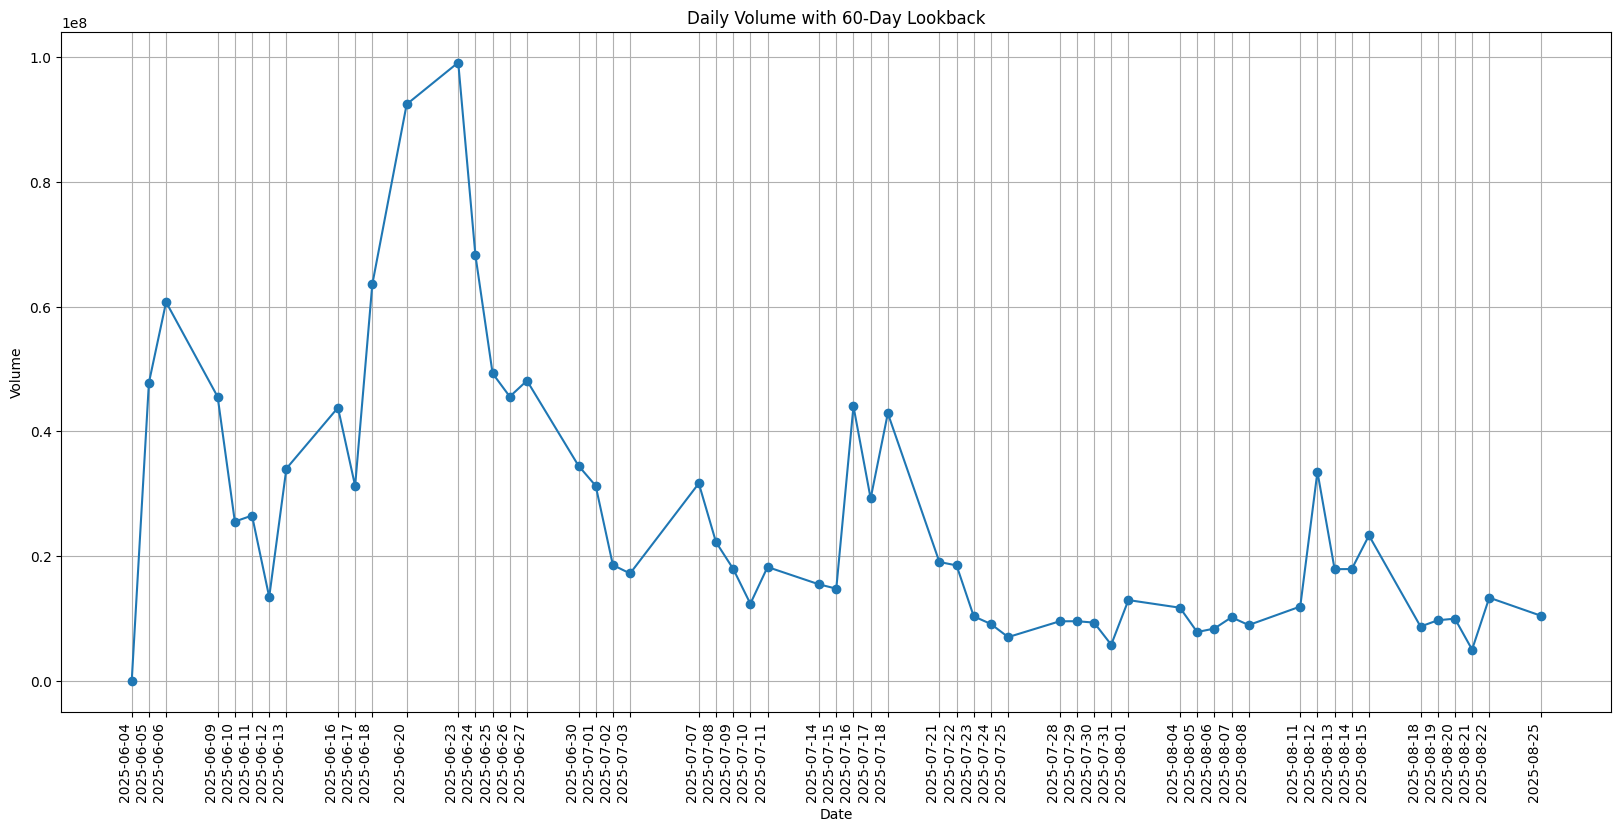

/Users/linguoren/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


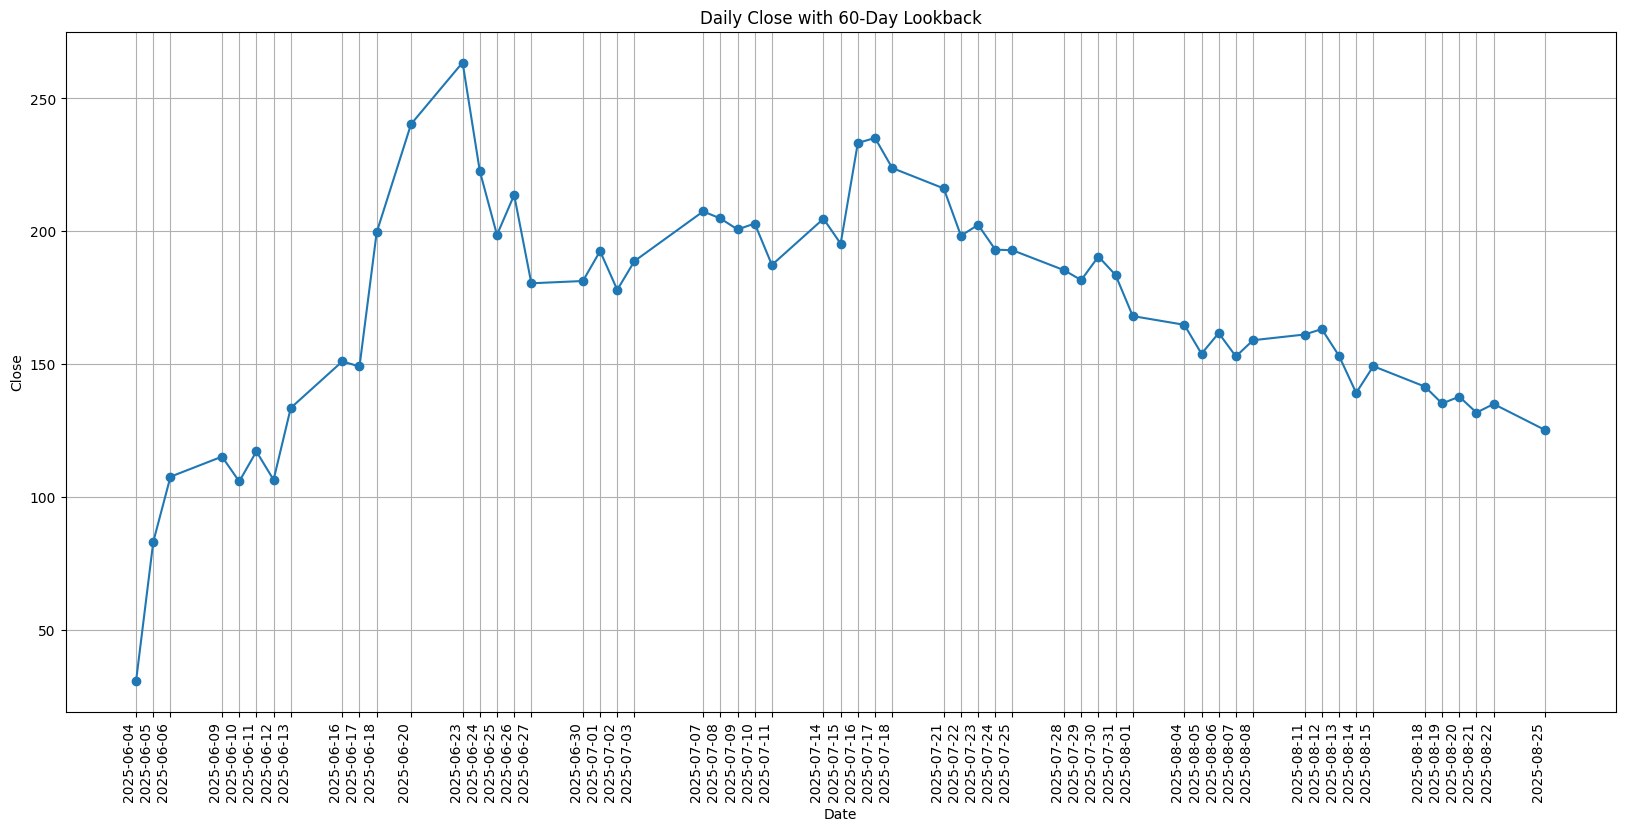

date
2025-06-04 00:00:00-04:00     31.00
2025-06-05 00:00:00-04:00     83.23
2025-06-06 00:00:00-04:00    107.70
2025-06-09 00:00:00-04:00    115.25
2025-06-10 00:00:00-04:00    105.91
2025-06-11 00:00:00-04:00    117.20
2025-06-12 00:00:00-04:00    106.54
2025-06-13 00:00:00-04:00    133.56
2025-06-16 00:00:00-04:00    151.06
2025-06-17 00:00:00-04:00    149.15
2025-06-18 00:00:00-04:00    199.59
2025-06-20 00:00:00-04:00    240.28
2025-06-23 00:00:00-04:00    263.45
2025-06-24 00:00:00-04:00    222.65
2025-06-25 00:00:00-04:00    198.62
2025-06-26 00:00:00-04:00    213.63
2025-06-27 00:00:00-04:00    180.43
2025-06-30 00:00:00-04:00    181.29
2025-07-01 00:00:00-04:00    192.53
2025-07-02 00:00:00-04:00    177.97
2025-07-03 00:00:00-04:00    188.77
2025-07-07 00:00:00-04:00    207.46
2025-07-08 00:00:00-04:00    204.81
2025-07-09 00:00:00-04:00    200.68
2025-07-10 00:00:00-04:00    202.90
2025-07-11 00:00:00-04:00    187.33
2025-07-14 00:00:00-04:00    204.70
2025-07-15 00:00:00-04:

In [315]:
df_3 = pd.read_csv("data/CRCL_daily_2025-07-28_to_2025-08-25.csv")
daily_data_feature(df_3, "volume", lookback=60)
daily_data_feature(df_3, "close", lookback=60)